# Practical Session 3 

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from copy import deepcopy

from tictactoe_env import TicTacToeEnv, DRAW
from utils import play, Agent, agent_vs_agent

from forban import *
from forban.bandits import NormalBandit, Normal
from forban.sequentialg import SequentiAlg
from forban.utils import *
import math

# Part I - Best Arm Identification

### Question 1

Recall the `forban` module.

On utilise le fichier "Forban" 
On importe le module et c'est avec ce module qu'on va pouvoir utiliser NormalBandit, Normal et d'autre outils du module

### Question 2

What are the three main parts of an exploration algorithm that aims to identify the best arm (*i.e.*, the arm having the largest mean).

<font color='green'>**Answer 2**</font>

- State :  C'est l'estimation de l'état actuel de chacun des bras
- Action : Le choix du bras à actionner
- Reward : Récompense reçu après le choix du bras

### Exploration class template

In [2]:
class Exploration(SequentiAlg):
    def __init__(self, bandit, name="Exploration", params={'init': 0, 'stoping criterion': None }):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.stoping_criterion = params['stoping criterion']
        
    def compute_indices(self):
        pass
            
    def choose_an_arm(self):
        return randamax(self.indices)
    
    def sampling(self):
        _ = self.pull(self.choose_an_arm())
    
    def recommendation(self):
        pass
    
    def stop(self):
        pass
    
    def run(self):
        while not self.stop():
            self.sampling()
            self.recommendation()

## Template for doing experiments

In [3]:
class Experiment:
    def __init__(self, sequential_algorithms, bandit,
                 statistics={'distance':True, 'proba':True, 'pulls':True}):
        assert len(sequential_algorithms) > 0
        self.algorithms = sequential_algorithms
        self.bandit = bandit
        self.nbr_algo = len(sequential_algorithms)
        self.algo_idx = 0
        self.statistics = {}
        self.nbr_exp = None
        for algo_idx, algo in enumerate(self.algorithms):
            self.statistics[algo_idx] = {'name': algo.name}
            for s in statistics.items():
                if s[1]:
                    self.statistics[algo_idx][s[0]] = None
        stats = self.statistics[0].keys()
        self.stats = stats

    def run(self, nbr_exp=500):
        self.nbr_exp = nbr_exp
        for algo_idx, algo in enumerate(self.algorithms):
            reco_arms = np.zeros(nbr_exp+self.bandit.nbr_arms, int)
            delta = np.zeros(nbr_exp+self.bandit.nbr_arms)
            pulls = np.zeros(nbr_exp, int)
            for i in range(nbr_exp):
                
                algo.reset()
                algo.run()
                
                reco_arms[i] = algo.recommendation()
                delta[i] = self.bandit.regrets[reco_arms[i]]
                pulls[i] = np.sum(algo.nbr_pulls)
            
            reco_arms[nbr_exp:] = np.arange(self.bandit.nbr_arms)
            delta[nbr_exp:] = self.bandit.regrets
            for k in self.stats:
                if k == 'distance':
                    self.statistics[algo_idx][k] = delta.copy()
                elif k == 'proba':
                    self.statistics[algo_idx][k] = reco_arms.copy()
                elif k == 'pulls':
                    self.statistics[algo_idx]['pulls'] = pulls.copy()
                    
    def plot(self, normalisation=False):
        exp_info = f"Nbr. of experiments = {self.nbr_exp}"
        ticks = np.arange(self.bandit.nbr_arms)
        if 'proba' in self.stats:
            plt.figure(figsize=(12,5))
            title = "Histogram of recommendation\n"
            title += exp_info
            plt.title(title)
            plt.xlabel("Arm", fontsize=14)
            plt.xticks(ticks, [str(i) for i in range(self.bandit.nbr_arms)])
            
            n = self.nbr_algo
            w = 1/(2*n)
            
            for i, algo_stats in enumerate(self.statistics.values()):
                name = algo_stats['name']
                _, hist = np.unique(algo_stats['proba'], return_counts=True)
                hist = hist - np.ones(self.bandit.nbr_arms, int)
                if normalisation:
                    hist = hist / self.nbr_exp
                t = ticks + w*(i - (n-1)/2)
                plt.bar(t, hist, width=w, label=name, alpha=0.5)
    
            plt.legend()
            plt.show()
        
        ticks = np.sort(self.bandit.regrets)
        if 'distance' in self.stats:
            plt.figure(figsize=(12,5))
            title = "Histogram of recommendation regret\n"
            title += exp_info
            plt.title(title)
            plt.xlabel("Arm - regret", fontsize=14)
            idxs = np.argsort(self.bandit.regrets)
            tmp = self.bandit.regrets[idxs]
            tmp = np.abs(tmp[1:] - tmp[:-1])
            w = np.unique(tmp)
            w = w[w > 0]
            
            n = self.nbr_algo
            w = w[0] / (2*n)
            
            
            plt.xticks(ticks, [f"{idxs[i]} - {self.bandit.regrets[idxs[i]]:.3f}" for i in range(self.bandit.nbr_arms)])

            for i, algo_stats in enumerate(self.statistics.values()):
                name = algo_stats['name']
                delta = algo_stats['distance']
                _, hist = np.unique(delta, return_counts=True)
                hist = hist - np.ones(self.bandit.nbr_arms, int)
                if normalisation:
                    hist = hist / self.nbr_exp
                t = ticks + w*(i - (n-1)/2)
                plt.bar(t, hist, width=w, label=name, alpha=0.5)
    
            plt.legend()
            plt.show()

### Question 3
Using the `Exploration` class, implement an exploration algorithm with uniform allocation. Test different recommendation rules on different bandit problem (having different complexities as defined in the previous homework).

### Exempli Gratia

Please, try to implement your own version (*i.e.*, own uniform allocation sampling rule) of the following example. 

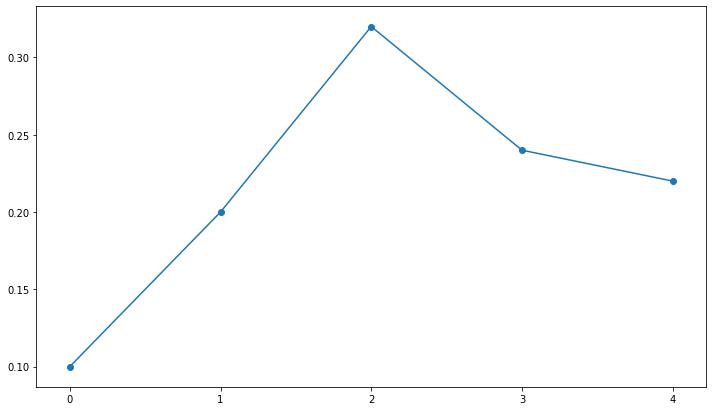

In [4]:
bandit_instance = NormalBandit([0.1, 0.2, 0.32, 0.24, 0.22])
plot_bandit(bandit_instance)

In [24]:
class ExplorationUniform(Exploration):
    def __init__(self, bandit, name="Exploration", params={'init': 0, 'stoping criterion': 500 }):
        Exploration.__init__(self, bandit, name=name, params=params)
        self.stoping_criterion = params['stoping criterion']
        
    def compute_indices(self):
        self.indices = np.random.randn(self.bandit.nbr_arms)
        # self.indices = - self.nbr_pulls
            
    def choose_an_arm(self):
        return randamax(self.indices)
    
    def sampling(self):
        _ = self.pull(self.choose_an_arm())
    
    def recommendation(self):
        return randamax(self.means)
    
    def stop(self):
        return self.time > self.stoping_criterion
    
    def run(self):
        while not self.stop():
            self.sampling()
            self.recommendation()

In [25]:
uniform_1 = ExplorationUniform(bandit_instance)
uniform_2 = ExplorationUniform(bandit_instance, name="Exploration 2", params={'init': 0, 'stoping criterion': 1500 })

In [27]:
expe = Experiment([uniform_1, uniform_2], bandit_instance)

In [28]:
expe.run(200)

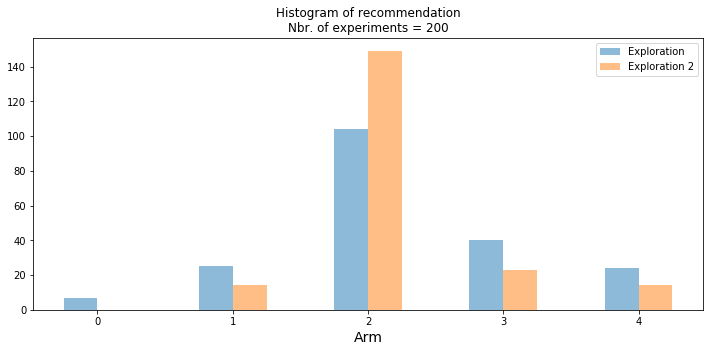

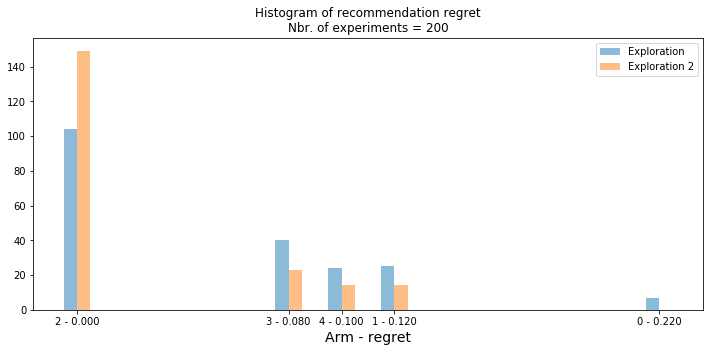

In [9]:
expe.plot()

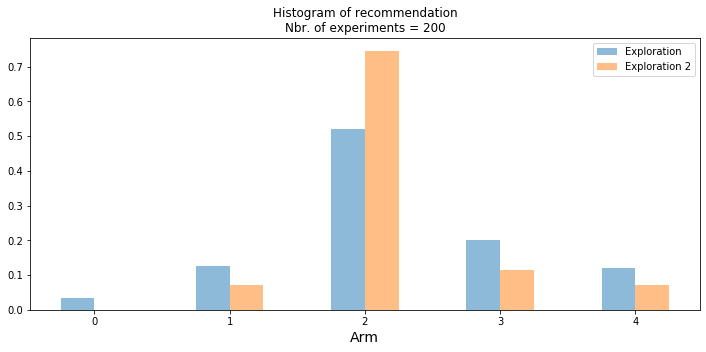

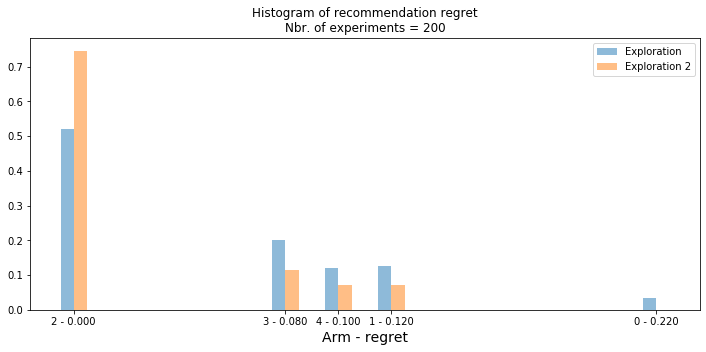

In [10]:
expe.plot(True)

### Please do your own

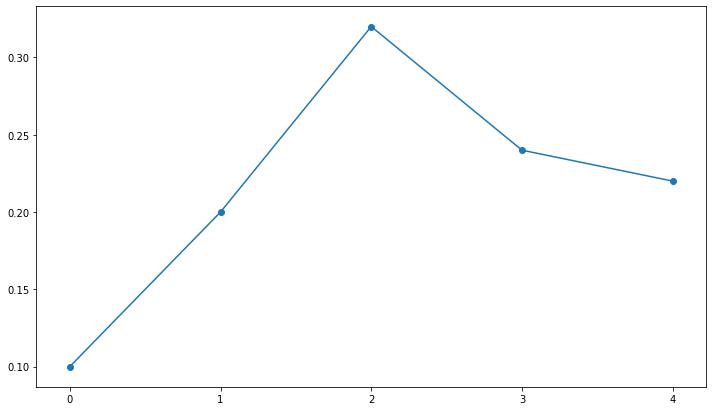

In [17]:
bandit_instance = NormalBandit([0.1, 0.2, 0.32, 0.24, 0.22])
plot_bandit(bandit_instance)

In [30]:
class ExplorationAllocUniform_1(Exploration):
    def __init__(self, bandit, name="Exploration", params={'init': 0, 'stoping criterion': 500 }):
        Exploration.__init__(self, bandit, name=name, params=params)
        self.stoping_criterion = params['stoping criterion']
        
    def compute_indices(self):
        self.indices = np.random.randn(self.bandit.nbr_arms)
        # self.indices = - self.nbr_pulls
            
    def choose_an_arm(self):
        return randamin(self.nbr_pulls)
    
    def sampling(self):
        _ = self.pull(self.choose_an_arm())
    
    def recommendation(self):
        return randamax(self.means)
    
    def stop(self):
        return self.time > self.stoping_criterion
    
    def run(self):
        while not self.stop():
            self.sampling()
            self.recommendation()

In [19]:
uniform_1 = ExplorationAllocUniform_1(bandit_instance)
uniform_2 = ExplorationAllocUniform_1(bandit_instance, name="Exploration 2", params={'init': 0, 'stoping criterion': 1500 })

In [20]:
expe = Experiment([uniform_1, uniform_2], bandit_instance)

In [21]:
expe.run(200)

In [23]:
uniform_1

Exploration algorithm - time step = 501
  Normal (mean=0.100, std=1.000) : est. mean = 0.157 - nbr. pulls = 100
  Normal (mean=0.200, std=1.000) : est. mean = 0.219 - nbr. pulls = 100
  Normal (mean=0.320, std=1.000) : est. mean = 0.333 - nbr. pulls = 100
  Normal (mean=0.240, std=1.000) : est. mean = 0.204 - nbr. pulls = 100
  Normal (mean=0.220, std=1.000) : est. mean = 0.197 - nbr. pulls = 101

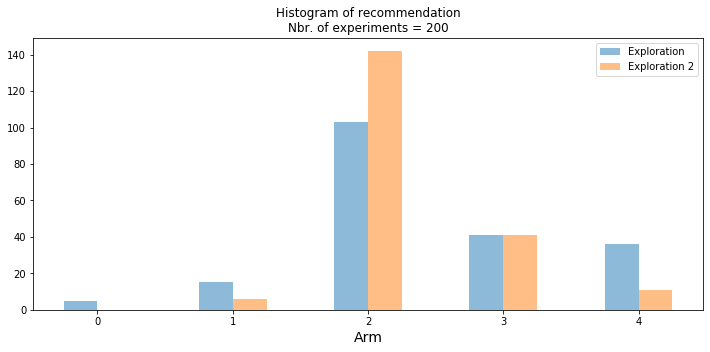

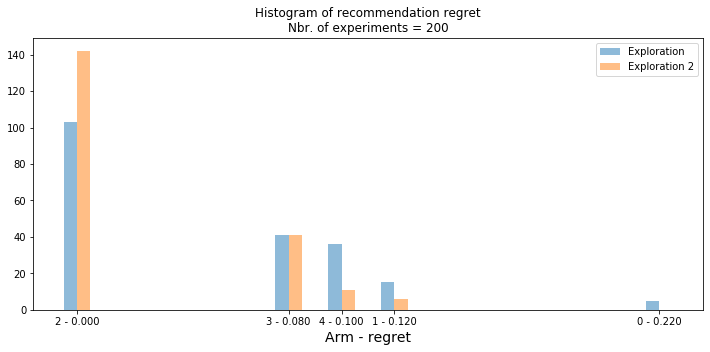

In [22]:
expe.plot()

#### Recommendation du bras le plus tiré, Par contre on enlève l'allocation uniforme

In [39]:
class ExplorationAllocUniform_2(Exploration):
    def __init__(self, bandit, name="Exploration", params={'init': 0, 'stoping criterion': 500 }):
        Exploration.__init__(self, bandit, name=name, params=params)
        self.stoping_criterion = params['stoping criterion']
        
    def compute_indices(self):
        self.indices = np.random.randn(self.bandit.nbr_arms)
        # self.indices = - self.nbr_pulls
            
    def choose_an_arm(self):
        return randamax(self.indices)
    
    def sampling(self):
        _ = self.pull(self.choose_an_arm())
    
    def recommendation(self):
        return randamax(self.nbr_pulls)
    
    def stop(self):
        return self.time > self.stoping_criterion
    
    def run(self):
        while not self.stop():
            self.sampling()
            self.recommendation()

In [40]:
bandit_instance = NormalBandit([0.1, 0.2, 0.32, 0.24, 0.22])

In [41]:
uniform_1 = ExplorationAllocUniform_2(bandit_instance)
uniform_2 = ExplorationAllocUniform_2(bandit_instance, name="Exploration 2", params={'init': 0, 'stoping criterion': 1500 })

In [42]:
expe = Experiment([uniform_1, uniform_2], bandit_instance)

In [43]:
expe.run(200)

In [44]:
uniform_1

Exploration algorithm - time step = 501
  Normal (mean=0.100, std=1.000) : est. mean = 0.233 - nbr. pulls = 100
  Normal (mean=0.200, std=1.000) : est. mean = 0.188 - nbr. pulls = 101
  Normal (mean=0.320, std=1.000) : est. mean = 0.221 - nbr. pulls = 82
  Normal (mean=0.240, std=1.000) : est. mean = 0.345 - nbr. pulls = 115
  Normal (mean=0.220, std=1.000) : est. mean = 0.054 - nbr. pulls = 103

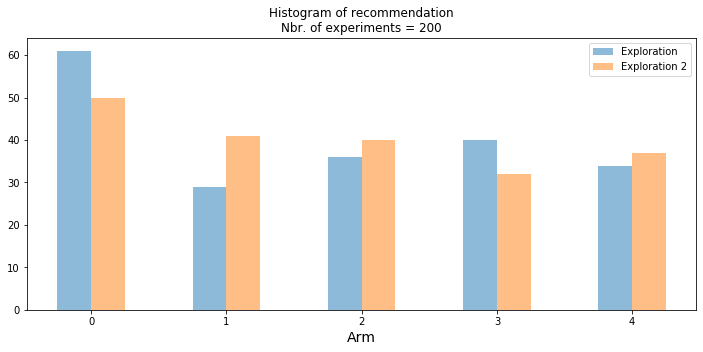

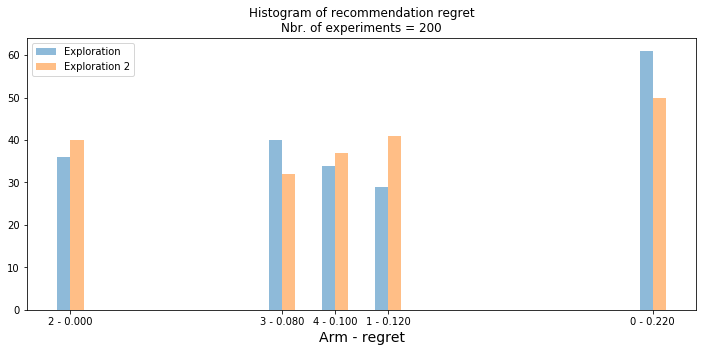

In [45]:
expe.plot()

### Question 4
Using the `Exploration` class, implement an UCB like exploration algorithm. Test different recommendation rules on different bandit problems (having different complexities as defined two sessions ago).

In [46]:
class ExplorationUCB_1(Exploration):
    def __init__(self, bandit, name="Exploration", params={'init': 0, 'stoping criterion': 500 }):
        Exploration.__init__(self, bandit, name=name, params=params)
        self.stoping_criterion = params['stoping criterion']
        
    def compute_indices(self):
        self.indices = self.means + np.sqrt(2 * np.log(self.time + 1) / (self.nbr_pulls +1))
        # self.indices = - self.nbr_pulls
            
    def choose_an_arm(self):
        return randamax(self.indices)
    
    def sampling(self):
        _ = self.pull(self.choose_an_arm())
    
    def recommendation(self):
        return randamax(self.means)
    
    def stop(self):
        return self.time > self.stoping_criterion
    
    def run(self):
        while not self.stop():
            self.sampling()
            self.recommendation()

In [47]:
bandit_instance = NormalBandit([0.1, 0.2, 0.32, 0.24, 0.22])

In [48]:
uniform_1 = ExplorationUCB_1(bandit_instance)
uniform_2 = ExplorationUCB_1(bandit_instance, name="Exploration 2", params={'init': 0, 'stoping criterion': 1500 })

In [49]:
expe = Experiment([uniform_1, uniform_2], bandit_instance)

In [50]:
expe.run(200)

In [51]:
uniform_1

Exploration algorithm - time step = 501
  Normal (mean=0.100, std=1.000) : est. mean = 0.196 - nbr. pulls = 90
  Normal (mean=0.200, std=1.000) : est. mean = 0.109 - nbr. pulls = 60
  Normal (mean=0.320, std=1.000) : est. mean = -0.334 - nbr. pulls = 15
  Normal (mean=0.240, std=1.000) : est. mean = 0.332 - nbr. pulls = 156
  Normal (mean=0.220, std=1.000) : est. mean = 0.303 - nbr. pulls = 180

In [52]:
uniform_2

Exploration 2 algorithm - time step = 1501
  Normal (mean=0.100, std=1.000) : est. mean = 0.246 - nbr. pulls = 366
  Normal (mean=0.200, std=1.000) : est. mean = 0.085 - nbr. pulls = 114
  Normal (mean=0.320, std=1.000) : est. mean = 0.293 - nbr. pulls = 602
  Normal (mean=0.240, std=1.000) : est. mean = 0.102 - nbr. pulls = 123
  Normal (mean=0.220, std=1.000) : est. mean = 0.224 - nbr. pulls = 296

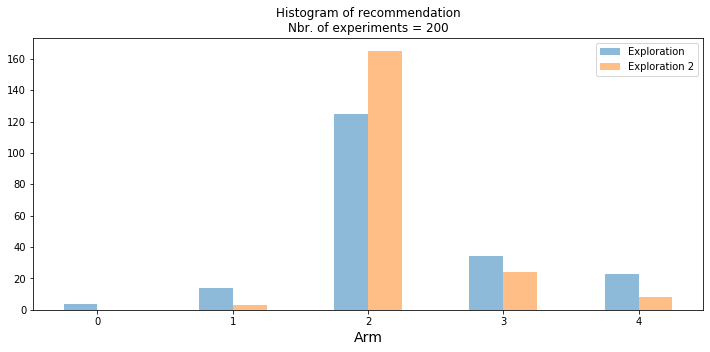

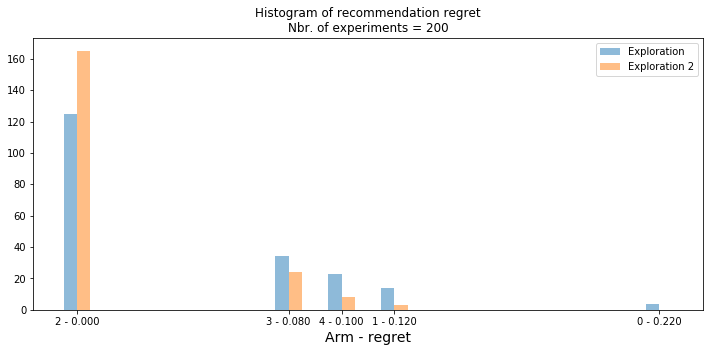

In [53]:
expe.plot()

### Question 5
Using the `Exploration` class, implement the sequential halving algorithm with a fixed budget. Test it on different bandit problems (having different complexities as defined two sessions ago).

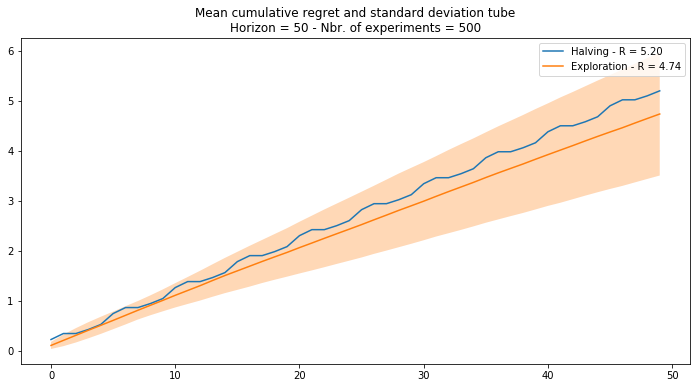

In [97]:
class SeqHalvAlg(Exploration):
    def __init__(self, bandit, name="Halving", params={'init': 0,'stoping criterion': 300, 'reco_fct':'EBA'}):
        Exploration.__init__(self, bandit, name=name, params=params)
        self.stoping_criterion = self.stoping_criterion / math.ceil( math.log(self.bandit.nbr_arms, 2) )
        self.next_arm = 0
        self.selected_arms = np.arange(self.bandit.nbr_arms)

    def recommendation(self):
        return(self.selected_arms[0])

    def choose_an_arm(self):
        return(self.next_arm)

    def update_statistics(self, arm, r):
        Exploration.update_statistics(self, arm, r)
        self.next_arm = (self.next_arm + 1) % len(self.means)
        while self.next_arm not in self.selected_arms:
            self.next_arm = (self.next_arm + 1) % len(self.means)

    def prune(self):
        median = statistics.median(np.array(self.means)[self.selected_arms])
        selection = []
        for i in self.selected_arms:
            if self.means[i] >= median:
                selection.append(i)
        self.selected_arms = np.array(selection)
        for i in range(self.bandit.nbr_arms):
            if i not in self.selected_arms:
                self.means[i] = -100



def fit(self, experiment, reset=True):
        if reset:
            self.reset()
        while len(self.selected_arms)>1:
            self.run()
            self.prune()
            self.time = 0
            self.next_arm = self.selected_arms[0]
        arm = self.recommendation()
        r = self.bandit.regrets[arm]
        return(arm,r)


bandit_instance = NormalBandit([0.1, 0.2, 0.32, 0.24, 0.22])
halvalg1 = SeqHalvAlg(bandit_instance)
UCBExp = ExplorationUCB_1(bandit_instance)
experiment = Experiment([halvalg1,UCBExp], bandit_instance)
experiment.run(500)
experiment.plot()

### Question 6
Do you think using structure would help for BAI?

Oui, on peut améliorer les performances de en utilisant une structure.
En effet, comme nous avons vu dans le TP précédent, dans le cas du Multi Armed Bandit on améliore les performances.
Dans le cas de BAI, c'est juste la structure du regret qui change (simple et pas cumulatif), donc on peut s'attendre à améliorer les performances dans ce cas de figure aussi comme dans le TP précédent.

# Part II -  Monte Carlo Tree Search

In this practical session, we will implement several MCTS heuristics and compare them. To do so, we will use a  Tic Tac Toe environement.

### Question 1
Recall and explain the idea behind MCTS and the four main steps of a MCTS.  

MCTS ou Monte Carlp Tree Search est un algorithme de recherche heuristique en explorant l'arbre des possibles <br>
Les Quatres étapes du MCTS sont :
* Selection : L'algorithme commence au nœud racine R, puis descend dans l'arbre en sélectionnant le nœud enfant optimal jusqu'à atteindre un nœud feuille L (aucun enfant connu jusqu'à présent).
* Expansion : Si L n'est pas un nœud terminal (il ne met pas fin au jeu), créez un ou plusieurs nœuds enfants en fonction des actions disponibles à l'état actuel (nœud), puis sélectionnez le premier de ces nouveaux nœuds M.
* Simulation : Exécutez un déploiement simulé à partir de M jusqu'à ce qu'un état terminal soit trouvé. L'état terminal contient un résultat (valeur) qui sera renvoyé vers le haut dans la phase de rétropropagation.
* Backpropagation : Après la phase de simulation, un résultat est renvoyé. Tous les nœuds de M à R seront mis à jour en ajoutant le résultat à leur valeur et en augmentant le nombre de visites à chaque nœud.

### Answer 1

## Tic Tac Toe environment

TicTacToeEnv is a custom envirionment based on the OpenAI gym library that we used for TD1.

In [98]:
env = TicTacToeEnv()
env.render()

# # #    |   1 2 3 
# # #    |   4 5 6 
# # #    |   7 8 9 




### Manual play

In [99]:
# Example game: each player plays randomly

# Always reset the environment at the start of a game
# (Remark : the reset method returns the initial state 
# of the envionment, i.e the board in the present case)
env.reset()
done = False
while not done:
    # Draw a position uniformly at random among the
    # remaining possible choices
    pos = env.sample()
    board, reward, done, _ = env.step(pos)
    # Display the board
    env.render()

winner = board.check_state()
if winner == DRAW:
    print("**      DRAW      **")
elif winner == 1:
    print("**      O WINS      **")
else:
    print("**      X WINS      **")

# # #    |   1 2 3 
# # #    |   4 5 6 
O # #    |   7 8 9 


# X #    |   1 2 3 
# # #    |   4 5 6 
O # #    |   7 8 9 


# X #    |   1 2 3 
# # O    |   4 5 6 
O # #    |   7 8 9 


# X #    |   1 2 3 
X # O    |   4 5 6 
O # #    |   7 8 9 


# X #    |   1 2 3 
X # O    |   4 5 6 
O O #    |   7 8 9 


X X #    |   1 2 3 
X # O    |   4 5 6 
O O #    |   7 8 9 


X X #    |   1 2 3 
X # O    |   4 5 6 
O O O    |   7 8 9 


**      O WINS      **


## Implementing a dummy agent

In [109]:
class DummyAgent(Agent):
    """Dummy TicTacToe agent that plays randomly.
    """
    def __init__(self, env, player=1, params={}):
        self._env = env
        self.player = player  # index of the player

    def play(self):
        """Syntax: play should be a method with no argument
        except self.
        In the present example, it simply calls the env attribute
        and use it to sample a feasible action.
        """
        return self.env.sample()

In [111]:
# Available input in the API: [1-9], 'quit', 'switch'
play(DummyAgent, game_env=env)

**        Tic Tac Toe Game        **
You are player 1 and you play the symbol O


# # #    |   1 2 3 
# # #    |   4 5 6 
# # #    |   7 8 9 
Where do you want to play? 1

O # #    |   - 2 3 
# X #    |   4 - 6 
# # #    |   7 8 9 
Where do you want to play? 9

O X #    |   - - 3 
# X #    |   4 - 6 
# # O    |   7 8 - 
Where do you want to play? 8

O X X    |   - - - 
# X #    |   4 - 6 
# O O    |   7 - - 
Where do you want to play? 7
1
********************
**     YOU WIN    **
********************




# # #    |   1 2 3 
# # #    |   4 5 6 
# # #    |   7 8 9 
Where do you want to play? quit


## Pitting two agents against one another 

100%|██████████| 1000/1000 [00:02<00:00, 338.74it/s, draw=13%, 0 wins=60%, X wins=27%]


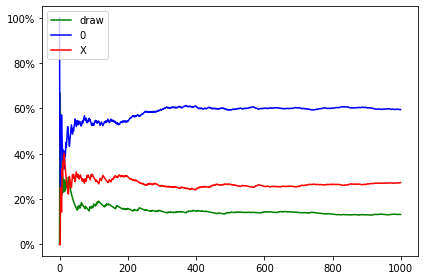

In [112]:
agent_vs_agent(env, DummyAgent, DummyAgent, n_episodes=1000, params1={}, params2={}, plot=True)

In [113]:
env = TicTacToeEnv(6*6)
env.render()

# # # # # #    |   1 2 3 4 5 6 
# # # # # #    |   7 8 9 10 11 12 
# # # # # #    |   13 14 15 16 17 18 
# # # # # #    |   19 20 21 22 23 24 
# # # # # #    |   25 26 27 28 29 30 
# # # # # #    |   31 32 33 34 35 36 




100%|██████████| 1000/1000 [00:15<00:00, 65.12it/s, draw=74%, 0 wins=13%, X wins=13%]


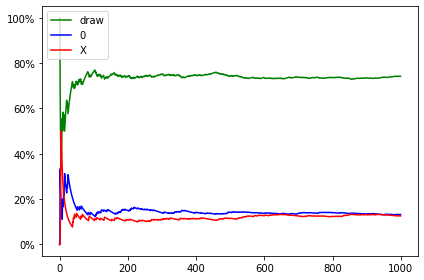

In [114]:
agent_vs_agent(env, DummyAgent, DummyAgent, n_episodes=1000, params1={}, params2={}, plot=True)

In [115]:
env = TicTacToeEnv(9*9)
env.render()

# # # # # # # # #    |   1 2 3 4 5 6 7 8 9 
# # # # # # # # #    |   10 11 12 13 14 15 16 17 18 
# # # # # # # # #    |   19 20 21 22 23 24 25 26 27 
# # # # # # # # #    |   28 29 30 31 32 33 34 35 36 
# # # # # # # # #    |   37 38 39 40 41 42 43 44 45 
# # # # # # # # #    |   46 47 48 49 50 51 52 53 54 
# # # # # # # # #    |   55 56 57 58 59 60 61 62 63 
# # # # # # # # #    |   64 65 66 67 68 69 70 71 72 
# # # # # # # # #    |   73 74 75 76 77 78 79 80 81 




100%|██████████| 1000/1000 [00:47<00:00, 21.03it/s, draw=96%, 0 wins=3%, X wins=1%]


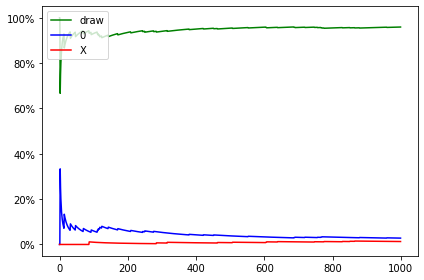

In [116]:
agent_vs_agent(env, DummyAgent, DummyAgent, n_episodes=1000, params1={}, params2={}, plot=True)

### Question 2

Comment the results of random vs random above. How do you explain that 'O' has the advantage despite playing at random?

### Answer 2

Dans le jeu de "Tic Tac Toe" le premier joueur, dans ce cas "O", a toujours l'avantage car il a un coup de plus que son adversaire (5 vs 4 dans le cas d'une table 3x3), et aussi étant donné que le vainqueur dans le jeu c'est le premier à alligner 3 cases, donc le premier joueur a un avantage considérable. <br>
On retrouve cet avantage lorsqu'on joue "bien", en effet le premier joueur est toujours sûr de ne pas perdre

## Monte Carlo Tree Search

A template class for MCTS is defined in mcts.py. It is an abstract class, and you need to instanciate the method search_heuristic, to guide the selection step of MCTS.

We first implement the uniform random search.

### Question 2

- Understand the pure exploration tree search heuristic implementation
- Implement the UCT algorithm

Feel free to experiment and implement other tree search policies (e.g., implement a pure exploitation tree search heuristic)

In [126]:
from mcts import MCTS

class MCTSPureExploration(MCTS):
    def __init__(self, player=1):
        super().__init__(player=player)

    def search_heuristic(self, node):
        """Pure exploration, uniformly choose how to
        explore the game tree.
        """
        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])
        
        return np.random.choice(list(self.children[node]))


class MCTSUCT(MCTS):
    def __init__(self, player=1, exploration_param=1.0):
        self.exploration_param = exploration_param
        super().__init__(player=player)
        
    
    

    def search_heuristic(self, node):
        """Upper Confidence bound for Trees.
        Balance exploration and exploitation in the game tree.
        """
        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])
        best_score = 0
        best_child = None
        for child in self.children[node] :
            score = self.W[child]/self.N[child] + self.exploration_param * np.sqrt(np.log(self.N[node])/(0.1+self.N[child]))
            if score >= best_score :
                best_score = score
                best_child = child
                
        return best_child
        
        
        # children is a dictionary of node -> set of children,
        # where node is a TicTacToeEnv, and the chidlren are
        # TicTacToeEnv corresponding to boards that are 
        # one action away from node.
        
        # self.W is a dictionary of node -> backpropagated rewards
        # self.N is a dictionary of node -> backpropagated number of visits
        
        ### TO IMPLEMENT
        

In [127]:
class MCTSAgent(Agent):
    """TicTacToe template agent that plays according to MCTS.
    """
    def __init__(self, env, player=1, params={'n_playouts': 1}):
        self.env = env
        self.player = player  # index of the player
        self.n_playouts = params.get('n_playouts', 1)
        # To be implemented in child class
        self.game_tree = None 
        
    def play(self):
        """Syntax: play should be a metbod without argument
        except self.
        """
        # Need to copy environment, so that MCTS internal simulations
        # do not affect the game being played
        env_copy = deepcopy(env)
        for _ in range(self.n_playouts):
            self.game_tree.playout(env_copy)
        return self.game_tree.choose(env_copy)


class MCTSPureExplorationAgent(MCTSAgent):
    """TicTacToe agent that plays according to MCTS Pure Exploration.
    """
    def __init__(self, env, player=1, params={'n_playouts': 1}):
        super().__init__(env=env, player=player, params=params)
        self.game_tree = MCTSPureExploration(player=player)

        
class MCTSUCTAgent(MCTSAgent):
    """TicTacToe agent that plays according to MCTS UCT.
    """
    def __init__(self, env, player=1, params={'n_playouts': 1, 'exploration_param': 1.0}):
        super().__init__(env=env, player=player, params=params)
        exploration_param = params.get('exploration_param', 1.0)
        self.game_tree = MCTSUCT(player=player, exploration_param=exploration_param)

### Manual play

In [128]:
env.reset()

agent1 = DummyAgent(env, player=1)
agent2 = MCTSUCTAgent(env, player=2, params={'n_playouts': 10, 'exploration_param': 1.0})

n_episodes = 10

for episode in range(n_episodes):
    done = False
    _ = env.reset()
    turn = 0

    while not done:
        if turn % 2 == 0:
            action = agent1.play()
        else:
            action = agent2.play()

        _, _, done, _ = env.step(action)

        turn += 1

        if done:
            break

    winner = env.board.check_state()
    if winner == DRAW:
        print("**      DRAW      **")
    elif winner == 1:
        print("**      O WINS      **")
    else:
        print("**      X WINS      **")

**      DRAW      **
**      DRAW      **
**      DRAW      **
**      DRAW      **
**      X WINS      **
**      DRAW      **
**      DRAW      **
**      DRAW      **
**      DRAW      **
**      DRAW      **


### Check MCTS tree

Je n'execute pas celle cellule car elle prend beaucoup de place dans le pdf du rendu de TP

In [134]:
#game_tree = agent2.game_tree
#children = game_tree.children
#print('Total number of nodes: {}\n'.format(len(children)))
#for node, successors in children.items():
#    print('Node')
#    node.render()
#    for successor in successors:
#        print('Child')
#        successor.render()
#    print('----------------------\n\n')

### AI vs AI

100%|██████████| 10/10 [1:04:56<00:00, 389.68s/it, draw=60%, 0 wins=0%, X wins=40%]


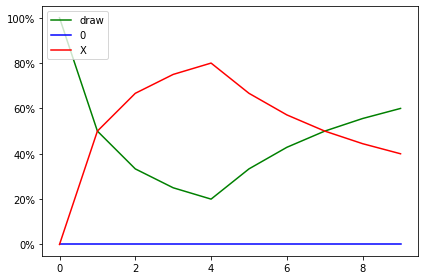

100%|██████████| 10/10 [1:14:10<00:00, 445.02s/it, draw=100%, 0 wins=0%, X wins=0%]


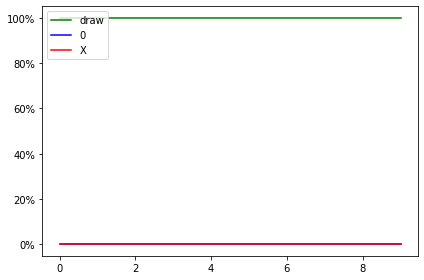

In [130]:
agent_vs_agent(env, DummyAgent, MCTSPureExplorationAgent, n_episodes=10, params1={}, params2={'n_playouts': 20}, plot=True)
agent_vs_agent(env, DummyAgent, MCTSUCTAgent, n_episodes=10, params1={}, params2={'n_playouts': 20}, plot=True)

### Question 3

Compare with the Q-Learning algorithm you have seen in TD1.

Comment on the behaviour of Q-Learning.

To you, what are the advantages and disadvantages of Q-Learning compared to MCTS?

Les avantages de MCTS : 
- Ne demande aucune connaissance sur le sujet en question (Tic Tac Toe) dans ce cas
- Se concentre sur la partie intéressante de l'arbre de décision 

Les inconvénients de MCTS : 
- Très lent, beaucoup de temps de calcul


In [131]:
from qlearning import QFunction, QLearningAgent, random_vs_Q_learning, Q_learning_vs_random

class QLearningAgent(Agent):
    """Dummy TicTacToe agent that plays randomly.
    """
    def __init__(self, env, player=1, params={'Q': None}):
        self._env = env
        self.player = player  # index of the player
        Q = params.get('Q', None)
        if Q is not None:
            self.Q = Q
        else:
            self.Q = QFunction(nbr_pos=env.nbr_pos)

    def play(self):
        """Syntax: play should be a metbod without argument
        except self.
        """
        return self.Q.get_argmax_action_Q_idx(self.env.state(), self.env)

In [132]:
GAMMA = 0.99
n_episodes = int(1e4)
learning_rate = 0.1
epsilon_greedy = 0.9
epsilon_greedy_decay_freq = 50
epsilon_greedy_decay_factor = 0.9

Q_opt_Q_learning_cross, stats = random_vs_Q_learning(
    env,
    n_episodes,
    learning_rate,
    epsilon_greedy,
    epsilon_greedy_decay_freq,
    epsilon_greedy_decay_factor,
    gamma=GAMMA,
)

Q_opt_Q_learning_nought, stats = Q_learning_vs_random(
    env,
    n_episodes,
    learning_rate,
    epsilon_greedy,
    epsilon_greedy_decay_freq,
    epsilon_greedy_decay_factor,
    gamma=GAMMA,
)

ValueError: Maximum allowed dimension exceeded

In [133]:
agent_vs_agent(env, QLearningAgent, MCTSUCTAgent, n_episodes=10, params1={'Q': Q_opt_Q_learning_nought.Q}, params2={'n_playouts': 20}, plot=True)

NameError: name 'Q_opt_Q_learning_nought' is not defined

# Practical Session 3 -  Best Arm Identification

### Question 0

Recall the `forban` module.

### Question 1

What are the three main parts of an exploration algorithm that aims to identify the best arm (*i.e.*, the arm having the largest mean).